In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [3]:
# 세 번째 예: 이상 감지
# 개요
# 이 예에서는 ECG5000 데이터세트에서 이상을 감지하도록 autoencoder를 훈련합니다.
#  이 데이터세트에는 각각 140개의 데이터 포인트가 있는 5,000개의 심전도가 포함되어 있습니다.
#  단순화 된 버전의 데이터세트를 사용하고, 각 예제는 0(비정상 리듬에 해당) 또는 1(정상 리듬에 해당)으로 레이블이 지정됩니다.
#  여러분은 비정상 리듬을 식별하는 데 관심이 있습니다.

# 참고: 레이블이 지정된 데이터세트를 사용하므로 지도 학습 문제라고 표현할 수 있습니다.
#  이 예의 목표는 사용 가능한 레이블이 없는 더 큰 데이터세트에 적용할 수 있는 이상 감지 개념을 설명하는 것입니다
#  (예: 정상 리듬이 수천 개이고 비정상 리듬이 적은 경우).

# autoencoder를 사용하여 이상을 어떻게 감지하겠습니까? autoencoder는 재구성 오류를 최소화하도록 훈련되었습니다.
#  autoencoder는 정상 리듬으로만 훈련한 다음 이 autoencoder를 사용하여 모든 데이터를 재구성합니다.
#  여기서 가설은 비정상 리듬의 경우에 재구성 오류가 더 클 것이라는 것입니다.
#  그런 다음 재구성 오류가 고정 임계값을 초과하는 경우, 리듬을 이상으로 분류합니다.

In [4]:
# ECG 데이터 로드하기
# 사용할 데이터세트는 timeseriesclassification.com의 데이터세트를 기반으로 합니다.
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()
# 5 rows × 141 columns

# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [11]:
# DataFrame.head(n=5): Parameters ==> nint, default 5
print(type(dataframe.head()))
# <class 'pandas.core.frame.DataFrame'>
print(dataframe.head().shape)
# (5, 141)

<class 'pandas.core.frame.DataFrame'>
(5, 141)


In [12]:
# NumPy ndarray Indexing :  기본적인 조작은 list와 같다.
# x[start : stop : step] 이 그대로 적용된다. 물론 start는 이상, stop은 미만이다
x2 = np.random.randint(10, size=(3, 4))
print(x2.shape)
# (3, 4)
print(x2)
# [[0 1 4 1]
#  [5 8 6 2]
#  [8 0 8 1]]

(3, 4)
[[2 7 2 1]
 [8 6 0 2]
 [5 0 3 7]]


In [6]:
# >>> x2[:2, :3]		# 행 2개, 열 3개
print(x2[:2, :3])
# [[0 1 4]
#  [5 8 6]]

# 기존 파이썬 list에서 li[::-1]로 하면 거꾸로된 list를 구할 수 있듯이,
#  다음과 같은 방법으로 거꾸로 된 2d 배열을 구할 수 있다.
# >>> x2[::-1, ::-1]
print(x2[::-1, ::-1])
# [[1 8 0 8]
#  [2 6 8 5]
#  [1 4 1 0]]

[[4 5 0]
 [1 0 4]]
[[1 1 1 8]
 [4 4 0 1]
 [0 0 5 4]]


In [7]:
print(x2)
# [[0 1 4 1]
#  [5 8 6 2]
#  [8 0 8 1]]

# x1[0]		# 0번째(첫번째) element 접근
# x1[-1]		# 마지막 element 접근
print(x2[:,-1])
# [1 2 1]

print(x2.shape)
# (3, 4)
print(x2[:,-1].shape) # 마지막 열
# (3,)

[[4 5 0 0]
 [1 0 4 4]
 [8 1 1 1]]
[0 4 1]
(3, 4)
(3,)


In [9]:
print(raw_data.shape)
# (4998, 141)
print(raw_data[:, -1].shape)
# (4998,)

(4998, 141)
(4998,)


In [10]:
# The last element contains the labels # 마지막 열
labels = raw_data[:, -1] 

print(type(labels))
# <class 'numpy.ndarray'>
print(labels.shape)
# (4998,)

<class 'numpy.ndarray'>
(4998,)


In [13]:
# 데이터를 [0,1]로 정규화합니다.
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [14]:
# 이 데이터세트에서 1로 레이블이 지정된 정상 리듬만 사용하여 autoencoder를 훈련합니다.
#  정상 리듬과 비정상 리듬을 분리합니다.

train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

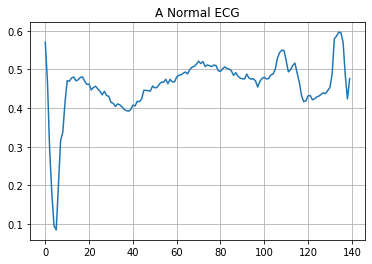

In [15]:
# 정상적인 ECG를 플롯합니다.
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

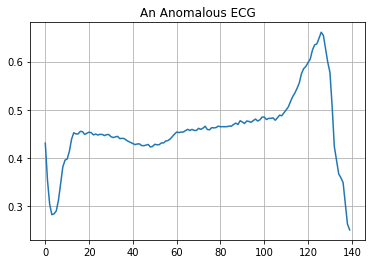

In [16]:
# 비정상적인 ECG를 플롯합니다.
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [17]:
# 모델 빌드하기
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

autoencoder.compile(optimizer='adam', loss='mae')

Epoch 1/20
5/5 [==============================] - 2s 29ms/step - loss: 0.0577 - val_loss: 0.0531
Epoch 2/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0551 - val_loss: 0.0514
Epoch 3/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0510 - val_loss: 0.0492
Epoch 4/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0466 - val_loss: 0.0465
Epoch 5/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0419 - val_loss: 0.0439
Epoch 6/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0375 - val_loss: 0.0416
Epoch 7/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0334 - val_loss: 0.0396
Epoch 8/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0303 - val_loss: 0.0383
Epoch 9/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0282 - val_loss: 0.0371
Epoch 10/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0267 - val_loss: 0.0364
Epoch 11/20
5/5 [=====================

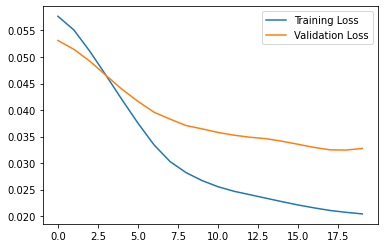

In [18]:
# autoencoder는 일반 ECG만 사용하여 훈련되지만, 전체 테스트세트를 사용하여 평가됩니다.
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

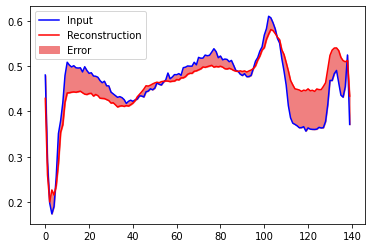

In [19]:
# 재구성 오류가 정상 훈련 예제에서 하나의 표준 편차보다 큰 경우, ECG를 비정상으로 분류합니다.
#  먼저, 훈련 세트의 정상 ECG, autoencoder에 의해 인코딩 및 디코딩된 후의 재구성, 재구성 오류를 플롯해 보겠습니다.
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

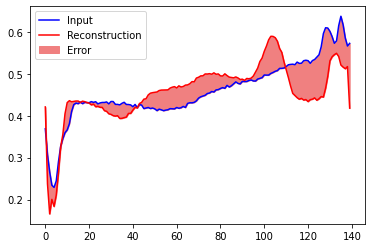

In [20]:
# 이번에는 비정상적인 테스트 예제에서 비슷한 플롯을 만듭니다.
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [21]:
# 이상 감지하기
# 재구성 손실이 고정 임계값보다 큰지 여부를 계산하여 이상을 감지합니다.
#  이 튜토리얼에서는 훈련 세트에서 정상 예제에 대한 평균 오차를 계산한 다음,
#  재구성 오류가 훈련 세트의 표준 편차보다 큰 경우 향후 예제를 비정상적인 것으로 분류합니다.

In [40]:
# 훈련 세트에서 정상 ECG에 대한 재구성 오류를 플롯합니다.

reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

In [41]:
# 히스토그램 (Histogram)은 도수분포표를 그래프로 나타낸 것으로서, 가로축은 계급, 세로축은 도수 (횟수나 개수 등)를 나타냅니다.
# hist() 함수의 bins 파라미터는 히스토그램의 가로축 구간의 개수를 지정합니다

print(type(train_loss))
# <class 'tensorflow.python.framework.ops.EagerTensor'>
print(train_loss.shape)
(2359,)

print(type(train_loss[None,:]))
# <class 'tensorflow.python.framework.ops.EagerTensor'>
print(train_loss[None,:].shape)
# (1, 2359)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(2359,)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 2359)


In [61]:
print("train_loss mean: ", np.mean(train_loss))
print("train_loss std: ", np.std(train_loss))

train_loss mean:  0.020257441
train_loss std:  0.011912717


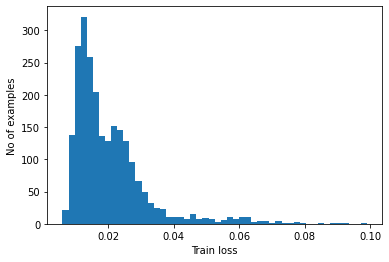

In [58]:
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

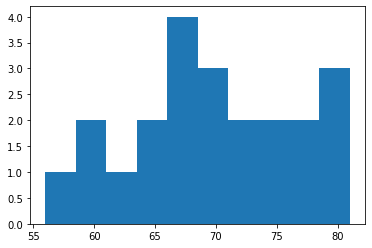

In [56]:
weight = [68, 81, 64, 56, 78, 74, 61, 77, 66, 68,
          59, 71, 80, 59, 67, 81, 69, 73, 69, 74,
          70, 65]
plt.hist(weight)
plt.show()

In [48]:
# 평균보다 표준 편차가 높은 임계값을 선택합니다.
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.032170158


In [59]:
# 참고: 테스트 예제를 이상 항목으로 분류하는 임계값을 선택하는 데 사용할 수 있는 다른 전략이 있습니다.
#  올바른 접근 방식은 데이터세트에 따라 다릅니다.
#  이 튜토리얼의 끝에 있는 링크를 통해 더 많은 것을 배울 수 있습니다.

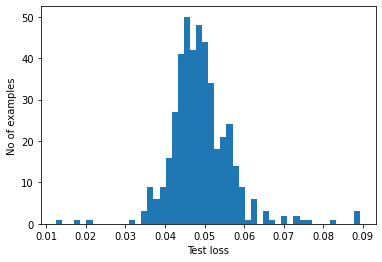

In [50]:
# 테스트 세트에서 비정상적인 예제에 대한 재구성 오류를 조사하면 대부분 임계값보다 더 큰 재구성 오류가 있음을 알 수 있습니다.
#  임계값을 변경하여 분류자의 정밀도와 재현율을 조정할 수 있습니다.
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [60]:
# 재구성 오류가 임계값보다 큰 경우 ECG를 이상으로 분류합니다.
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.942
Precision = 0.9921568627450981
Recall = 0.9035714285714286


In [23]:
# 다음 단계
# autoencoder를 사용한 이상 탐지에 대해 자세히 알아보려면 Victor Dibia가 TensorFlow.js로 빌드한 훌륭한 대화형 예제를 확인하세요.
#  실제 사용 사례의 경우, TensorFlow를 사용하여 Airbus가 ISS 원격 측정 데이터에서 이상을 감지하는 방법을 알아볼 수 있습니다.
#  기본 사항에 대해 자세히 알아보려면 François Chollet의 블로그 게시물을 읽어보세요.
#  자세한 내용은 Ian Goodfellow, Yoshua Bengio, Aaron Courville의 딥 러닝에서 14장을 확인하세요.